# FedFromScratch
## A local implementation of the Federated Learning algorithm (FedAvg) in plain torch


## Introduction

Federated Learning is a distributed machine learning approach that allows training a global model across multiple devices or servers holding local data samples, without exchanging them. The idea is to train a global model by averaging the local models of each device. This way, the data remains on the device, and only the model is shared. This approach is particularly useful when the data is sensitive and cannot be shared, or when the data is too large to be centralized.

More formally, the Federated Learning algorithm can be described as follows:

1. Initialize the global model parameters $\theta$.
2. For each round $r$ in $1, \ldots, R$:
    1. For each `client` $k$ in $1, \ldots, K$:
        1. Send the global model parameters $\theta$ to device $k$.
        2. Train the local models $\theta_k$ using the local data $D_k$ (possibly non iid): $\theta_k \leftarrow \eta_k\nabla_\theta\mathcal{L}(\mathbf{y}, \mathbf{l})$.
        3. Send the local model parameters $\theta_k$ to the server.
    2. Update the global model parameters $\theta \leftarrow \theta = \frac{1}{K} \sum_{k=1}^K \theta_k$
3. Return the global model parameters $\theta$.

In this notebook, we will implement the Federated Learning algorithm in plain torch, using the MNIST dataset. We will use a simple CNN model, and we will train it emulating clients behavior by running each client on a separate process through Joblib. Implementation details and code are proided in the "models.py" file.

Note that we are making simplyfiying assumptions in this implementation, such as the fact that all clients are trained together and they have the same number of samples. In practice, the data is often non-iid, and the clients have different number of samples, or are not available together to train. For this project purposes, we will keep the implementation simple and focus on the core idea of Federated Learning.

## Basic setup and "monolithic" training of the model

In the following cell, we will define the basic setup for the training of the model. We will define the model, the loss function, the optimizer, and the data loaders. We will train the model on the whole dataset to have a baseline to compare the Federated Learning approach.

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


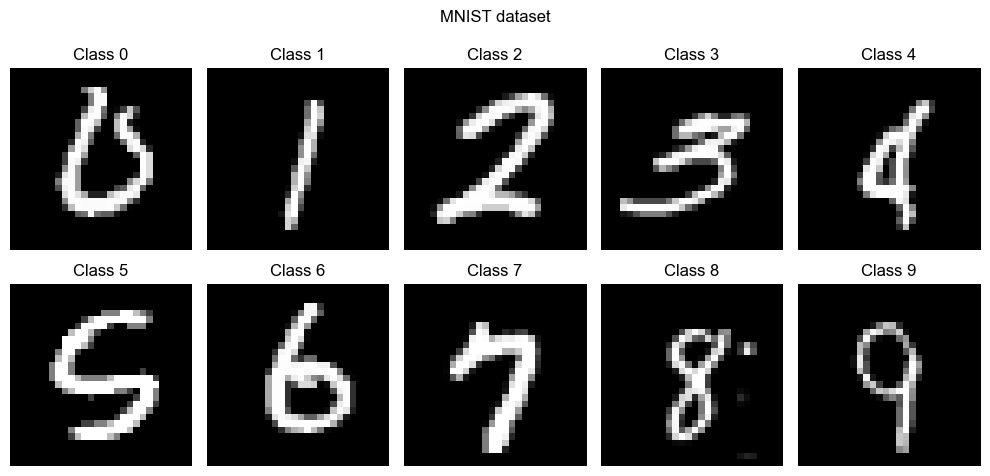

In [8]:
# set autoreload
%load_ext autoreload
%autoreload 2

from models import MNISTConvNet, MNISTFederatedServer, get_mnist_dataloader, init_clients, MNISTConvNetTrainer
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import numpy as np
from utils import plot_mnist

# firstly, we create the dataloader for the MNIST dataset
train, val, test = get_mnist_dataloader(64)
plot_mnist(train, 10, 5)

# set grid
sns.set_style('whitegrid')

In [ ]:
trainer = MNISTConvNetTrainer(
    MNISTConvNet(), 
    train,          # training set
    val,            # using validation set
    device='mps',   # training using Apple's Metal Performance Shaders, you can also use 'cuda' or 'cpu'
    weight_decay=1e-5,
    lr=0.01
)   

# training the model on the whole training sety (50000 samples), for 10 epochs.
# Optimizer is Adam, with a learning rate of 0.001 and a weight decay of 0.0001
# since this is a very simple task, we can safely ignore a proper model selection procedure.
trainer.train(16)
loss, accuracy = trainer.test(test)

print(f'Test loss: {loss:.4f}, accuracy: {accuracy:.4f}')

### We now have a solid baseline model that we will use to compare the performance of the Federated Learning approach.
Without model selelction and further tuning, we reached a CE loss of $0.0415$ and an accuracy of $98.59%$ on the blind test set.

Let's now test the Federated Learning approach. We will first test it on 10 clients, although the number of clients can be easily increased by changing the `n_clients` parameter.

We will train the same model architecture on each client, and according to the algorithm, we will average the weights of the models at the end of each round.  

Each client will draw a subset of 512 data points from the training set, and we will train the model for 5 epochs on each client. We will run 64 rounds of training (64 global updates), with 10 jobs running in parallel (my machine has 10 cores...): in this case, we are assuming that the data is IID across the clients; we will further release this assumption. These parameers reflect those of the original FedAvg paper.

> Note: with this simple setup, we will not implement any advanced techniques to improve the performance of the model, such as learning rate scheduling, early stopping, or data augmentation. The goal is to provide a simple implementation of the Federated Learning algorithm in plain torch. 

> Note: in the spirit of FedAvg, the server is not aware of the data distribution on the clients.

In [ ]:
model5e10c  = MNISTConvNet()
server5e10c = MNISTFederatedServer(model=model5e10c, test_loader=val)


# we first create 10 clients
clients = init_clients(
    num_clients=10, 
    local_epochs=5, 
    lr=1e-2, 
    train_dataset=train, 
    n_samples=512, 
    device='mps', 
    weight_decay=1e-6, 
    sample_method='iid'
)

loss_5, acc_5 = server5e10c.start_train(clients, n_rounds=64, n_jobs=10)

# save history
# save history
with open('../histories/history_5e10c.pkl', 'wb') as f:
    pickle.dump({'loss': loss_5, 'accuracy': acc_5}, f)

In [7]:
# test the model on the test set
server5e10c.test_loader = test
loss, accuracy = server5e10c.test()

print(f'Test loss: {loss:.4f}, accuracy: {accuracy:.4f}')

Test loss: 0.0780, accuracy: 0.9762


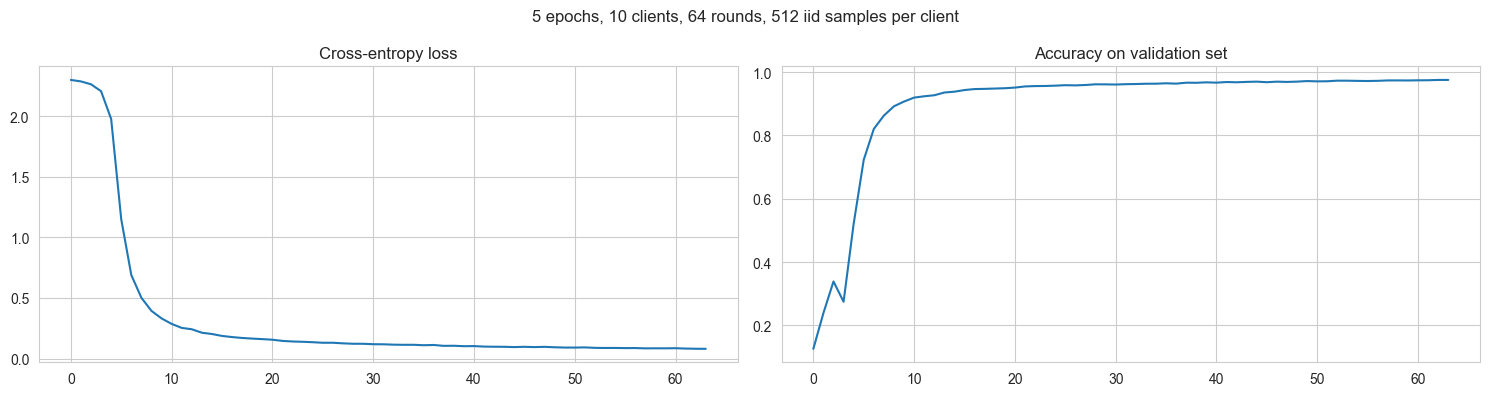

In [25]:
# plot history with seaborn

fig, axs = plt.subplots(1, 2, figsize=(15, 4))
axs[0].plot(loss_5)
axs[0].set_title('Cross-entropy loss')
axs[1].plot(acc_5)
axs[1].set_title('Accuracy on validation set')

# set suptitle
fig.suptitle('5 epochs, 10 clients, 64 rounds, 512 iid samples per client')
fig.tight_layout()
plt.show()

### It works! The model trained with Federated Learning reached a CE loss of $0.0780$ and an accuracy of $97.62\%$ on the blind test set.
(I think that there is still some margin for improvement, but the results are already quite good!)


## Testing fedavg on MNIST dataset with different numbers of epochs per client

In [ ]:
model5e  = MNISTConvNet()
server5e = MNISTFederatedServer(model=model5e, test_loader=val)

clients = init_clients(
   num_clients=5,
   local_epochs=5,
   lr=1e-2,
   train_dataset=train,
   n_samples=256,
   device='mps',
   weight_decay=1e-8,
   sample_method='iid'
)

loss_5e, acc_5e = server5e.start_train(clients, n_rounds=64, n_jobs=8)

# save history
with open('../histories/history_5e5c.pkl', 'wb') as f:
    pickle.dump({'loss': loss_5e, 'accuracy': acc_5e}, f)


model10e  = MNISTConvNet()
server10e = MNISTFederatedServer(model=model10e, test_loader=val)

clients = init_clients(
   num_clients=10,
   local_epochs=5,
   lr=1e-2,
   train_dataset=train,
   n_samples=256,
   device='mps',
   weight_decay=1e-8
)

loss_10e, acc_10e = server10e.start_train(clients, n_rounds=64, n_jobs=8)

# save history
with open('../histories/history_5e10c.pkl', 'wb') as f:
    pickle.dump({'loss': loss_10e, 'accuracy': acc_10e}, f)

model20e  = MNISTConvNet()
server20e = MNISTFederatedServer(model=model20e, test_loader=val)
clients = init_clients(
    num_clients=20,
    local_epochs=5,
    lr=1e-2,
    train_dataset=train,
    n_samples=256,
    device='mps',
    weight_decay=1e-8
)

loss_20e, acc_20e = server20e.start_train(clients, n_rounds=64, n_jobs=8)

# save history
with open('../histories/history_5e20c.pkl', 'wb') as f:
    pickle.dump({'loss': loss_20e, 'accuracy': acc_20e}, f)

In [14]:
# load histories and convert them to numpy arrays (i made the notebook in several days, so i saved the histories)
with open('../histories/history_5e5c.pkl', 'rb') as f:
    history_5e5c = pickle.load(f)
    loss_5e5c = np.array(history_5e5c['loss'])
    acc_5e5c = np.array(history_5e5c['accuracy'])

with open('../histories/history_5e10c.pkl', 'rb') as f:
    history_5e10c = pickle.load(f)
    loss_5e10c = np.array(history_5e10c['loss'])
    acc_5e10c = np.array(history_5e10c['accuracy'])

with open('../histories/history_5e20c.pkl', 'rb') as f:
    history_5e20c = pickle.load(f)
    loss_5e20c = np.array(history_5e20c['loss'])
    acc_5e20c = np.array(history_5e20c['accuracy'])


In [8]:
# test all models
server5e.test_loader = test
server10e.test_loader = test
server20e.test_loader = test

loss_5e, acc_5e = server5e.test()
loss_10e, acc_10e = server10e.test()
loss_20e, acc_20e = server20e.test()

print(f'5 clients, 5 epochs, 256 samples iid: {acc_5e:.2%}')
print(f'10 clients, 5 epochs, 256 samples iid: {acc_10e:.2%}')
print(f'20 clients, 5 epochs, 256 samples iid: {acc_20e:.2%}')

5 clients, 5 epochs, 256 samples iid: 96.20%
10 clients, 5 epochs, 256 samples iid: 96.04%
20 clients, 5 epochs, 256 samples iid: 96.31%


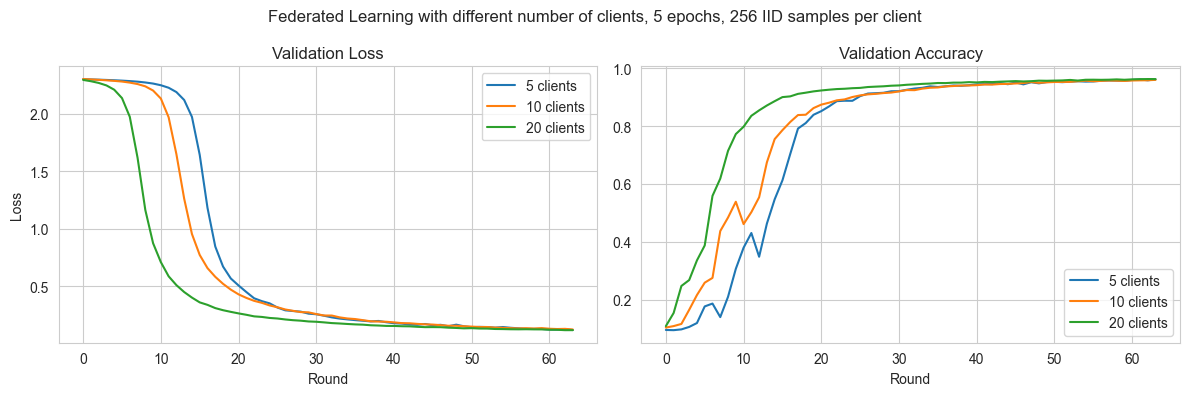

In [22]:
import matplotlib.pyplot as plt
import seaborn as sns

# set grid
sns.set_style('whitegrid')

# plot the losses and accuracies
fig, axs = plt.subplots(1, 2, figsize=(12, 4))

axs[0].plot(loss_5e5c, label='5 clients')
axs[0].plot(loss_5e10c, label='10 clients')
axs[0].plot(loss_5e20c, label='20 clients')
axs[0].set_title('Validation Loss')
axs[0].set_xlabel('Round')
axs[0].set_ylabel('Loss')
axs[0].legend()

axs[1].plot(acc_5e5c, label='5 clients')
axs[1].plot(acc_5e10c, label='10 clients')
axs[1].plot(acc_5e20c, label='20 clients')
axs[1].set_title('Validation Accuracy')
axs[1].set_xlabel('Round')
axs[1].legend()

# set super title
plt.suptitle('Federated Learning with different number of clients, 5 epochs, 256 IID samples per client')
# add some space between the plots
plt.tight_layout()

plt.show()



### Brief comment on the results of this experiment

This results show how all configurations were able to reach satisfying performances and, as I was expecting, the higher the number of the clients, the higher the faster the convergence. However, all models will eventually converge to a stable point. The results are quite good and impressing, considering the low number of data points sampled by each client and the simplicity of the tested CNN used.
We will now proceed to assess performance of federated learning on a more "realistic" scenario, with many clients and small data samples for client.

### Now, let's test federated learning with many clients, each one sampling very few data points from the training set. Again, the distribution is iid across the clients.
This expetiment aims to simulate a more realistic scenario where the data samples are few and distributed across many clients. We will use 128 clients, each one drawing 32 data points from the training set. We will train the model for 5 epochs on each client, and we will run 64 rounds of training with 16 jobs running in parallel.

In [ ]:
model5e128c  = MNISTConvNet()
server = MNISTFederatedServer(model=model5e128c, test_loader=val)

clients = init_clients(
   num_clients=128,
   local_epochs=5,
   lr=1e-2,
   train_dataset=train,
   n_samples=32,
   device='mps',
   weight_decay=1e-10,
   sample_method='iid'
)

loss5e128c, acc5e128c = server.start_train(clients, n_rounds=128, n_jobs=10)

# save history
with open('history_5e128c.pkl', 'wb') as f:
    pickle.dump({'loss': loss5e128c, 'accuracy': acc5e128c}, f)

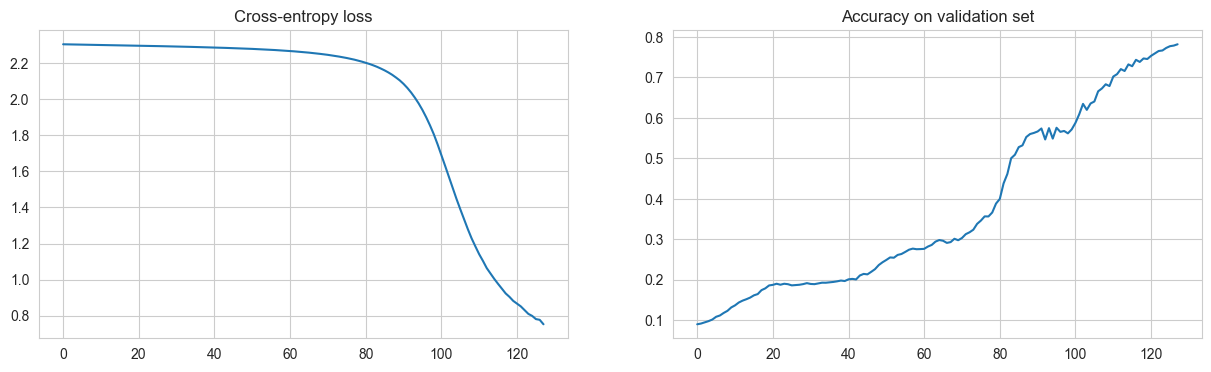

In [29]:
with open('../histories/history_5e128c.pkl', 'rb') as f:
    history = pickle.load(f)

loss5e128c = history['loss']
acc_5e128c = history['accuracy']

fig, axs = plt.subplots(1, 2, figsize=(15, 4))
axs[0].plot(loss5e128c)
axs[0].set_title('Cross-entropy loss')
 
axs[1].plot(acc_5e128c)
axs[1].set_title('Accuracy on validation set')
plt.show()

### Convergence is really slow.
However, after many rounds, model suddently starts to improve and generalize. This suggests exactly what we would expect in a federated learning scenario: the model is able to learn from the local data of each client, and it is able to generalize to the global data distribution. This is a very interesting result, and it shows the potential of Federated Learning in real-world scenarios. Moreover, in a more realistic setting, where clients only have to fine-tune the model (e.g. few-shot learning), it is my opinion that the convergence would be much faster.

We will now proceed to test the federated learning performance on a more realistic scenario, where the data is non-iid across the clients.

## The pathological case: non-iid data distribution across the clients

In a federated learning application (e.g. keyboard text prediction) we must release the assumption that the data is iid across the clients: we can have sampling bias and different data distributions across the clients, e.g. different languages, different writing styles, etc. We will try to check how the model performs in this case.

Experimental setup:
In order to simulate what the authors of the original FedAvg refer to "pathological non iid case" we will split the MNIST dataset in 10 shards, each one containing the images of two digits. This is a very simple (though extreme) way to create a non-iid data distribution across the clients. We will then train the model on 10 clients, each one holding a different sample of its assigned digits.

Full code of this split is straightforward and it is reported in the following snippet for completeness:

```python

    def _sample_data_noniid(self):
        # select all samples with that key
        subset = [s for s in self.train_loader.dataset if s[1] == self.k % 10]
        subset = Subset(subset, list(RandomSampler(subset, num_samples=self.n_samples)))
        return DataLoader(subset, batch_size=32, shuffle=True)
```

I expect this setup to be very challenging for the model, since we are again starting from a random weights configuration and averaging models trained on completely different data.

In [6]:
model_niid  = MNISTConvNet()
server_niid = MNISTFederatedServer(model=model_niid, test_loader=val)

clients = init_clients(
   num_clients=16,
   local_epochs=5,
   lr=1e-2,
   train_dataset=train,
   n_samples=256,
   device='mps',
   weight_decay=1e-10,
   sample_method='niid'
)

loss_niid, acc_niid = server_niid.start_train(clients, n_rounds=64, n_jobs=8)

> Client 0 created, lr: 0.01, epochs: 5, samples: 256, device: mps, weight_decay: 1e-10
> Client 1 created, lr: 0.01, epochs: 5, samples: 256, device: mps, weight_decay: 1e-10
> Client 2 created, lr: 0.01, epochs: 5, samples: 256, device: mps, weight_decay: 1e-10
> Client 3 created, lr: 0.01, epochs: 5, samples: 256, device: mps, weight_decay: 1e-10
> Client 4 created, lr: 0.01, epochs: 5, samples: 256, device: mps, weight_decay: 1e-10
> Client 5 created, lr: 0.01, epochs: 5, samples: 256, device: mps, weight_decay: 1e-10
> Client 6 created, lr: 0.01, epochs: 5, samples: 256, device: mps, weight_decay: 1e-10
> Client 7 created, lr: 0.01, epochs: 5, samples: 256, device: mps, weight_decay: 1e-10
> Client 8 created, lr: 0.01, epochs: 5, samples: 256, device: mps, weight_decay: 1e-10
> Client 9 created, lr: 0.01, epochs: 5, samples: 256, device: mps, weight_decay: 1e-10
> Client 10 created, lr: 0.01, epochs: 5, samples: 256, device: mps, weight_decay: 1e-10
> Client 11 created, lr: 0.01, 

100%|███████████████████████████████████████████| 16/16 [00:07<00:00,  2.23it/s]


Aggregating 16 local states

Round 0, Test Loss: 2.2994437217712402, Test Acc: 0.0983


100%|███████████████████████████████████████████| 16/16 [00:04<00:00,  3.35it/s]


Aggregating 16 local states

Round 1, Test Loss: 2.3981502056121826, Test Acc: 0.0985


100%|███████████████████████████████████████████| 16/16 [00:04<00:00,  3.31it/s]


Aggregating 16 local states

Round 2, Test Loss: 2.339109420776367, Test Acc: 0.2066


100%|███████████████████████████████████████████| 16/16 [00:05<00:00,  3.18it/s]


Aggregating 16 local states

Round 3, Test Loss: 2.230863332748413, Test Acc: 0.265


100%|███████████████████████████████████████████| 16/16 [00:05<00:00,  3.14it/s]


Aggregating 16 local states

Round 4, Test Loss: 2.142805576324463, Test Acc: 0.2929


100%|███████████████████████████████████████████| 16/16 [00:05<00:00,  3.17it/s]


Aggregating 16 local states

Round 5, Test Loss: 2.001939535140991, Test Acc: 0.3484


100%|███████████████████████████████████████████| 16/16 [00:04<00:00,  3.28it/s]


Aggregating 16 local states

Round 6, Test Loss: 1.9045511484146118, Test Acc: 0.3614


100%|███████████████████████████████████████████| 16/16 [00:05<00:00,  3.17it/s]


Aggregating 16 local states

Round 7, Test Loss: 1.7818690538406372, Test Acc: 0.3875


100%|███████████████████████████████████████████| 16/16 [00:05<00:00,  3.16it/s]


Aggregating 16 local states

Round 8, Test Loss: 1.6759791374206543, Test Acc: 0.4018


100%|███████████████████████████████████████████| 16/16 [00:04<00:00,  3.20it/s]


Aggregating 16 local states

Round 9, Test Loss: 1.5776872634887695, Test Acc: 0.4286


100%|███████████████████████████████████████████| 16/16 [00:05<00:00,  3.15it/s]


Aggregating 16 local states

Round 10, Test Loss: 1.4903079271316528, Test Acc: 0.4561


100%|███████████████████████████████████████████| 16/16 [00:05<00:00,  3.12it/s]


Aggregating 16 local states

Round 11, Test Loss: 1.4173418283462524, Test Acc: 0.4896


100%|███████████████████████████████████████████| 16/16 [00:05<00:00,  3.18it/s]


Aggregating 16 local states

Round 12, Test Loss: 1.3348588943481445, Test Acc: 0.5181


100%|███████████████████████████████████████████| 16/16 [00:05<00:00,  3.20it/s]


Aggregating 16 local states

Round 13, Test Loss: 1.2866023778915405, Test Acc: 0.552


100%|███████████████████████████████████████████| 16/16 [00:05<00:00,  3.17it/s]


Aggregating 16 local states

Round 14, Test Loss: 1.2430496215820312, Test Acc: 0.5689


100%|███████████████████████████████████████████| 16/16 [00:05<00:00,  3.19it/s]


Aggregating 16 local states

Round 15, Test Loss: 1.2058275938034058, Test Acc: 0.5785


100%|███████████████████████████████████████████| 16/16 [00:05<00:00,  3.18it/s]


Aggregating 16 local states

Round 16, Test Loss: 1.1640195846557617, Test Acc: 0.6025


100%|███████████████████████████████████████████| 16/16 [00:04<00:00,  3.20it/s]


Aggregating 16 local states

Round 17, Test Loss: 1.1503019332885742, Test Acc: 0.6133


100%|███████████████████████████████████████████| 16/16 [00:04<00:00,  3.24it/s]


Aggregating 16 local states

Round 18, Test Loss: 1.1163170337677002, Test Acc: 0.626


100%|███████████████████████████████████████████| 16/16 [00:05<00:00,  3.06it/s]


Aggregating 16 local states

Round 19, Test Loss: 1.0837310552597046, Test Acc: 0.642


100%|███████████████████████████████████████████| 16/16 [00:05<00:00,  3.13it/s]


Aggregating 16 local states

Round 20, Test Loss: 1.0541281700134277, Test Acc: 0.6479


100%|███████████████████████████████████████████| 16/16 [00:05<00:00,  3.18it/s]


Aggregating 16 local states

Round 21, Test Loss: 1.0346325635910034, Test Acc: 0.6584


100%|███████████████████████████████████████████| 16/16 [00:05<00:00,  3.09it/s]


Aggregating 16 local states

Round 22, Test Loss: 1.0025532245635986, Test Acc: 0.6716


100%|███████████████████████████████████████████| 16/16 [00:05<00:00,  3.18it/s]


Aggregating 16 local states

Round 23, Test Loss: 0.9935575127601624, Test Acc: 0.6743


100%|███████████████████████████████████████████| 16/16 [00:05<00:00,  3.14it/s]


Aggregating 16 local states

Round 24, Test Loss: 0.9609469175338745, Test Acc: 0.6867


100%|███████████████████████████████████████████| 16/16 [00:05<00:00,  3.17it/s]


Aggregating 16 local states

Round 25, Test Loss: 0.9671475291252136, Test Acc: 0.6917


100%|███████████████████████████████████████████| 16/16 [00:04<00:00,  3.22it/s]


Aggregating 16 local states

Round 26, Test Loss: 0.9399101138114929, Test Acc: 0.6936


100%|███████████████████████████████████████████| 16/16 [00:05<00:00,  3.12it/s]


Aggregating 16 local states

Round 27, Test Loss: 0.9099358916282654, Test Acc: 0.7045


100%|███████████████████████████████████████████| 16/16 [00:04<00:00,  3.27it/s]


Aggregating 16 local states

Round 28, Test Loss: 0.88487309217453, Test Acc: 0.7129


100%|███████████████████████████████████████████| 16/16 [00:04<00:00,  3.22it/s]


Aggregating 16 local states

Round 29, Test Loss: 0.9120534658432007, Test Acc: 0.6993


100%|███████████████████████████████████████████| 16/16 [00:05<00:00,  3.12it/s]


Aggregating 16 local states

Round 30, Test Loss: 0.8643870949745178, Test Acc: 0.7224


100%|███████████████████████████████████████████| 16/16 [00:04<00:00,  3.23it/s]


Aggregating 16 local states

Round 31, Test Loss: 0.8396047353744507, Test Acc: 0.7288


100%|███████████████████████████████████████████| 16/16 [00:05<00:00,  3.18it/s]


Aggregating 16 local states

Round 32, Test Loss: 0.8454254269599915, Test Acc: 0.7229


100%|███████████████████████████████████████████| 16/16 [00:05<00:00,  3.16it/s]


Aggregating 16 local states

Round 33, Test Loss: 0.8084315657615662, Test Acc: 0.745


100%|███████████████████████████████████████████| 16/16 [00:04<00:00,  3.20it/s]


Aggregating 16 local states

Round 34, Test Loss: 0.816645622253418, Test Acc: 0.7363


100%|███████████████████████████████████████████| 16/16 [00:05<00:00,  3.16it/s]


Aggregating 16 local states

Round 35, Test Loss: 0.7796168923377991, Test Acc: 0.7502


100%|███████████████████████████████████████████| 16/16 [00:04<00:00,  3.20it/s]


Aggregating 16 local states

Round 36, Test Loss: 0.7849843502044678, Test Acc: 0.7415


100%|███████████████████████████████████████████| 16/16 [00:05<00:00,  3.10it/s]


Aggregating 16 local states

Round 37, Test Loss: 0.7379839420318604, Test Acc: 0.7697


100%|███████████████████████████████████████████| 16/16 [00:05<00:00,  3.15it/s]


Aggregating 16 local states

Round 38, Test Loss: 0.7424403429031372, Test Acc: 0.7568


100%|███████████████████████████████████████████| 16/16 [00:05<00:00,  3.12it/s]


Aggregating 16 local states

Round 39, Test Loss: 0.7179201245307922, Test Acc: 0.7715


100%|███████████████████████████████████████████| 16/16 [00:05<00:00,  3.06it/s]


Aggregating 16 local states

Round 40, Test Loss: 0.7350935339927673, Test Acc: 0.7582


100%|███████████████████████████████████████████| 16/16 [00:04<00:00,  3.23it/s]


Aggregating 16 local states

Round 41, Test Loss: 0.7089214324951172, Test Acc: 0.7736


100%|███████████████████████████████████████████| 16/16 [00:05<00:00,  3.17it/s]


Aggregating 16 local states

Round 42, Test Loss: 0.6911477446556091, Test Acc: 0.7773


100%|███████████████████████████████████████████| 16/16 [00:05<00:00,  3.11it/s]


Aggregating 16 local states

Round 43, Test Loss: 0.68209308385849, Test Acc: 0.7838


100%|███████████████████████████████████████████| 16/16 [00:05<00:00,  3.18it/s]


Aggregating 16 local states

Round 44, Test Loss: 0.6897180676460266, Test Acc: 0.773


100%|███████████████████████████████████████████| 16/16 [00:05<00:00,  3.09it/s]


Aggregating 16 local states

Round 45, Test Loss: 0.6667505502700806, Test Acc: 0.7836


100%|███████████████████████████████████████████| 16/16 [00:05<00:00,  3.16it/s]


Aggregating 16 local states

Round 46, Test Loss: 0.6583820581436157, Test Acc: 0.7901


100%|███████████████████████████████████████████| 16/16 [00:05<00:00,  3.14it/s]


Aggregating 16 local states

Round 47, Test Loss: 0.644384503364563, Test Acc: 0.7897


100%|███████████████████████████████████████████| 16/16 [00:04<00:00,  3.20it/s]


Aggregating 16 local states

Round 48, Test Loss: 0.643896222114563, Test Acc: 0.79


100%|███████████████████████████████████████████| 16/16 [00:04<00:00,  3.24it/s]


Aggregating 16 local states

Round 49, Test Loss: 0.6123208403587341, Test Acc: 0.8091


100%|███████████████████████████████████████████| 16/16 [00:04<00:00,  3.20it/s]


Aggregating 16 local states

Round 50, Test Loss: 0.6203173995018005, Test Acc: 0.8048


100%|███████████████████████████████████████████| 16/16 [00:04<00:00,  3.21it/s]


Aggregating 16 local states

Round 51, Test Loss: 0.6359416246414185, Test Acc: 0.7931


100%|███████████████████████████████████████████| 16/16 [00:04<00:00,  3.26it/s]


Aggregating 16 local states

Round 52, Test Loss: 0.5916719436645508, Test Acc: 0.8119


100%|███████████████████████████████████████████| 16/16 [00:04<00:00,  3.21it/s]


Aggregating 16 local states

Round 53, Test Loss: 0.5848405957221985, Test Acc: 0.8159


100%|███████████████████████████████████████████| 16/16 [00:05<00:00,  3.16it/s]


Aggregating 16 local states

Round 54, Test Loss: 0.5753871202468872, Test Acc: 0.8171


100%|███████████████████████████████████████████| 16/16 [00:04<00:00,  3.21it/s]


Aggregating 16 local states

Round 55, Test Loss: 0.565051257610321, Test Acc: 0.825


100%|███████████████████████████████████████████| 16/16 [00:04<00:00,  3.23it/s]


Aggregating 16 local states

Round 56, Test Loss: 0.5641275644302368, Test Acc: 0.82


100%|███████████████████████████████████████████| 16/16 [00:05<00:00,  3.16it/s]


Aggregating 16 local states

Round 57, Test Loss: 0.5527546405792236, Test Acc: 0.82


100%|███████████████████████████████████████████| 16/16 [00:04<00:00,  3.26it/s]


Aggregating 16 local states

Round 58, Test Loss: 0.5457073450088501, Test Acc: 0.8279


100%|███████████████████████████████████████████| 16/16 [00:05<00:00,  3.20it/s]


Aggregating 16 local states

Round 59, Test Loss: 0.541689932346344, Test Acc: 0.8271


100%|███████████████████████████████████████████| 16/16 [00:05<00:00,  3.10it/s]


Aggregating 16 local states

Round 60, Test Loss: 0.518459141254425, Test Acc: 0.8409


100%|███████████████████████████████████████████| 16/16 [00:05<00:00,  3.19it/s]


Aggregating 16 local states

Round 61, Test Loss: 0.5303769111633301, Test Acc: 0.8281


100%|███████████████████████████████████████████| 16/16 [00:05<00:00,  3.18it/s]


Aggregating 16 local states

Round 62, Test Loss: 0.5101070404052734, Test Acc: 0.8405


100%|███████████████████████████████████████████| 16/16 [00:05<00:00,  3.16it/s]


Aggregating 16 local states

Round 63, Test Loss: 0.5294782519340515, Test Acc: 0.8229


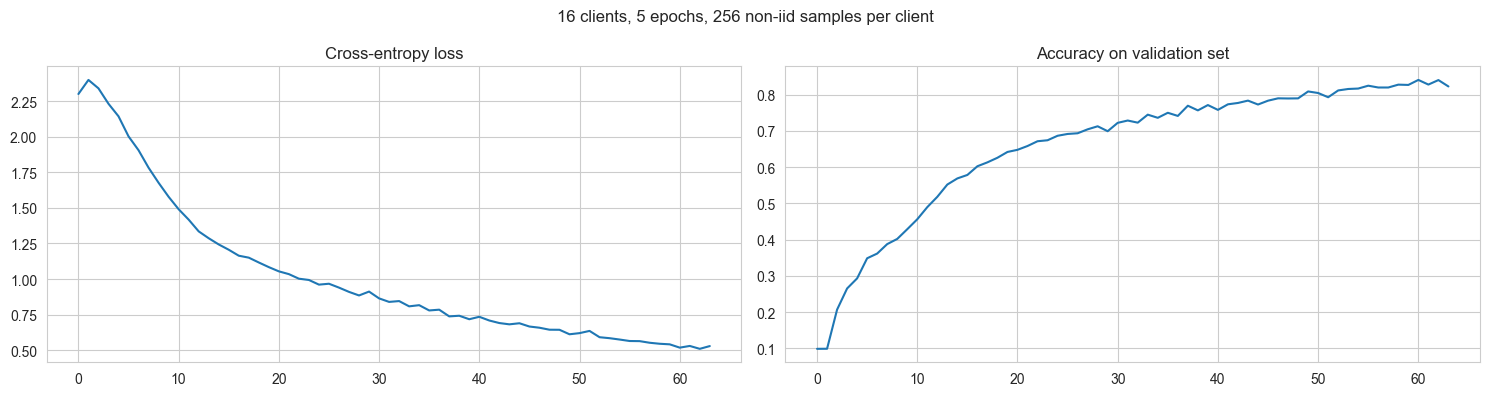

In [9]:
# save history
with open('../histories/history_niid.pkl', 'wb') as f:
    pickle.dump({'loss': loss_niid, 'accuracy': acc_niid}, f)

# plot history with seaborn
fig, axs = plt.subplots(1, 2, figsize=(15, 4))
axs[0].plot(loss_niid)
axs[0].set_title('Cross-entropy loss')
axs[1].plot(acc_niid)
axs[1].set_title('Accuracy on validation set')

# set suptitle
fig.suptitle('16 clients, 5 epochs, 256 non-iid samples per client')
fig.tight_layout()
plt.show()